In [1]:
#pre requirements
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tensorflow==2.5.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.5.0

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!nvidia-smi

Mon Jan  8 01:50:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX150         WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   59C    P3              N/A / ERR! |     95MiB /  2048MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### Load data into tf dataset

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=200

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1410 files belonging to 6 classes.


### Check information

In [7]:
class_names = dataset.class_names
class_names

['Flowering Stage',
 'Fruit Formation Stage',
 'Germination Stage',
 'Ripening Stage',
 'Vegetative Stage',
 'no tomato plant detected']

In [8]:
len(dataset)

45

In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

#(batch_size, H, V, Channel)

(32, 256, 256, 3)
[[[[ 94.48016  132.83429   71.400696]
   [106.87134  142.40259   73.093994]
   [ 69.56012  106.12262   30.383911]
   ...
   [ 55.10785   85.986755  27.484802]
   [ 65.53308   97.53308   32.47632 ]
   [ 65.43359   98.49414   29.172485]]

  [[ 95.05078  132.05078   63.15326 ]
   [ 96.7793   130.7793    56.60901 ]
   [ 49.744812  81.821655  21.065063]
   ...
   [ 59.039734  87.96289   29.679077]
   [ 66.57654   99.22693   30.670715]
   [ 68.17291  106.97357   20.077087]]

  [[ 97.5484   133.53125   57.217896]
   [ 78.93878  112.777954  38.175842]
   [ 45.211304  74.2113    27.422241]
   ...
   [ 65.97443   94.07849   32.23651 ]
   [ 68.05475  104.82623   27.598389]
   [ 85.10571  130.612     24.187744]]

  ...

  [[136.52386  170.63281  135.44879 ]
   [130.89258  156.9909   113.75586 ]
   [115.08984  141.00037   99.93964 ]
   ...
   [ 23.916016  39.916016  13.916016]
   [ 23.141907  39.141907  13.141907]
   [ 23.567932  39.567932  12.567932]]

  [[135.74127  168.89752  1

## Visualize some of the images from our dataset

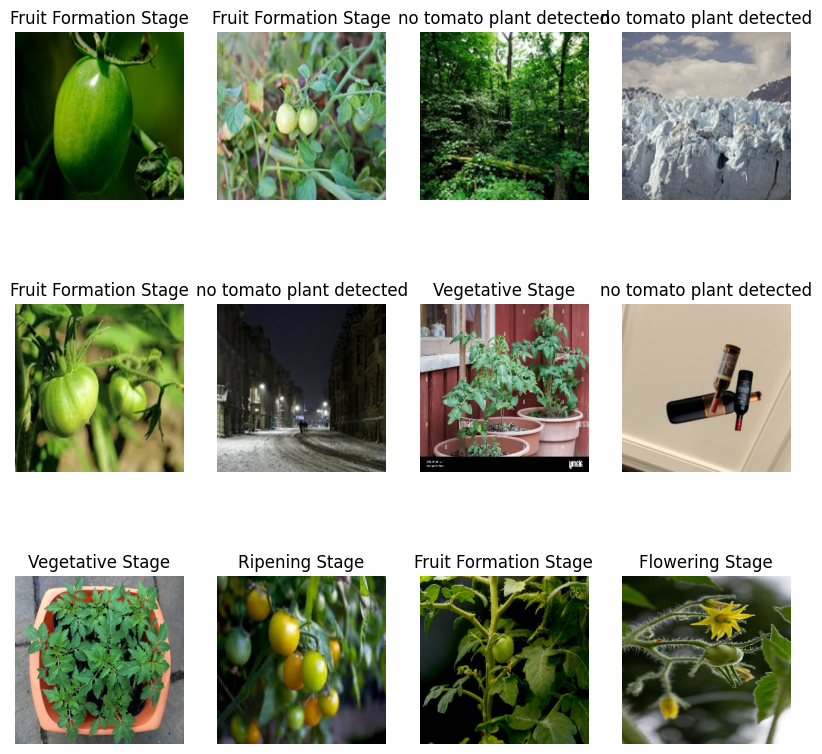

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model


In [11]:
len(dataset)

45

In [12]:
train_size = 0.8
trainDS=int(len(dataset)*train_size)

In [13]:
train_ds = dataset.take(trainDS) #taking the first trainDS elements
len(train_ds)

36

In [14]:
test_ds = dataset.skip(trainDS) #skipping the first trainDS elements
len(test_ds)

9

In [15]:
val_size=0.1
valDS=int(len(dataset)*val_size)

In [16]:
val_ds = test_ds.take(valDS)
len(val_ds)

4

In [17]:
test_ds = test_ds.skip(valDS)
len(test_ds)

5

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)


36

In [21]:
len(val_ds)


4

In [22]:
len(test_ds)


5

## Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model
### Creating a Layer for Resizing and Normalization

In [24]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

In [25]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### Applying Data Augmentation to Train Dataset

In [26]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),


    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/200
36/36 [==============================] - 134s 3s/step - loss: 1.7541 - accuracy: 0.1943 - val_loss: 1.4405 - val_accuracy: 0.3906
Epoch 2/200
36/36 [==============================] - 84s 2s/step - loss: 1.4957 - accuracy: 0.3565 - val_loss: 1.4920 - val_accuracy: 0.3281
Epoch 3/200
36/36 [==============================] - 85s 2s/step - loss: 1.4227 - accuracy: 0.3806 - val_loss: 1.1594 - val_accuracy: 0.5781
Epoch 4/200
36/36 [==============================] - 83s 2s/step - loss: 1.3237 - accuracy: 0.4554 - val_loss: 1.3939 - val_accuracy: 0.4297
Epoch 5/200
36/36 [==============================] - 83s 2s/step - loss: 1.2305 - accuracy: 0.5071 - val_loss: 1.1209 - val_accuracy: 0.5391
Epoch 6/200
36/36 [==============================] - 83s 2s/step - loss: 1.1164 - accuracy: 0.5490 - val_loss: 0.9640 - val_accuracy: 0.6172
Epoch 7/200
36/36 [==============================] - 83s 2s/step - loss: 1.0401 - accuracy: 0.5963 - val_loss: 0.9044 - val_accuracy: 0.5703
Epoch 8/200


In [31]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 12s 525ms/step - loss: 0.1085 - accuracy: 0.9625


In [32]:
history.params

{'verbose': 1, 'epochs': 200, 'steps': 36}

In [33]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7540887594223022,
 1.49568772315979,
 1.4226748943328857,
 1.3236873149871826,
 1.2305454015731812]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

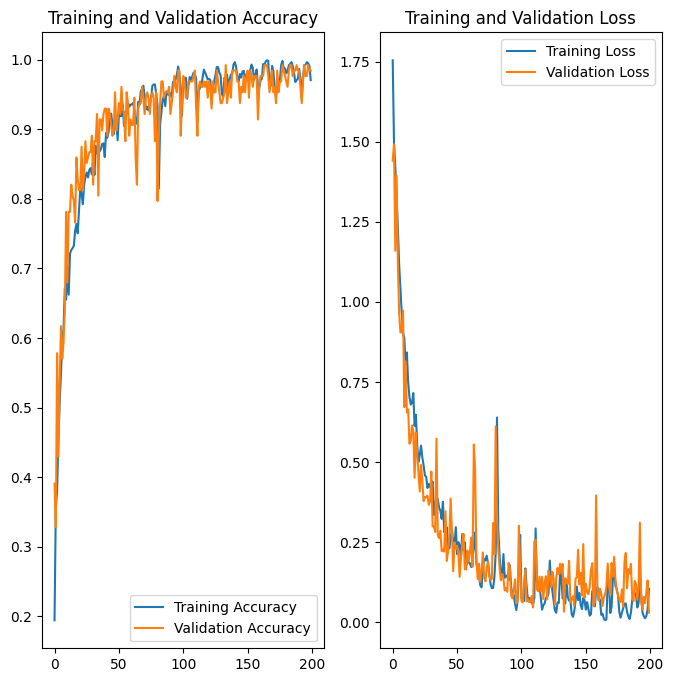

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Ripening Stage
1/1 [==============================] - 1s 642ms/step
predicted label: Ripening Stage


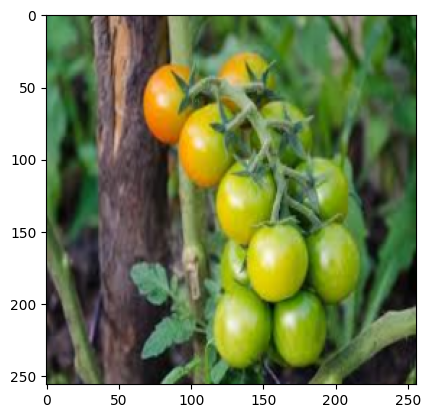

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Write a function for inference

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

1/1 [==============================] - 0s 47ms/step


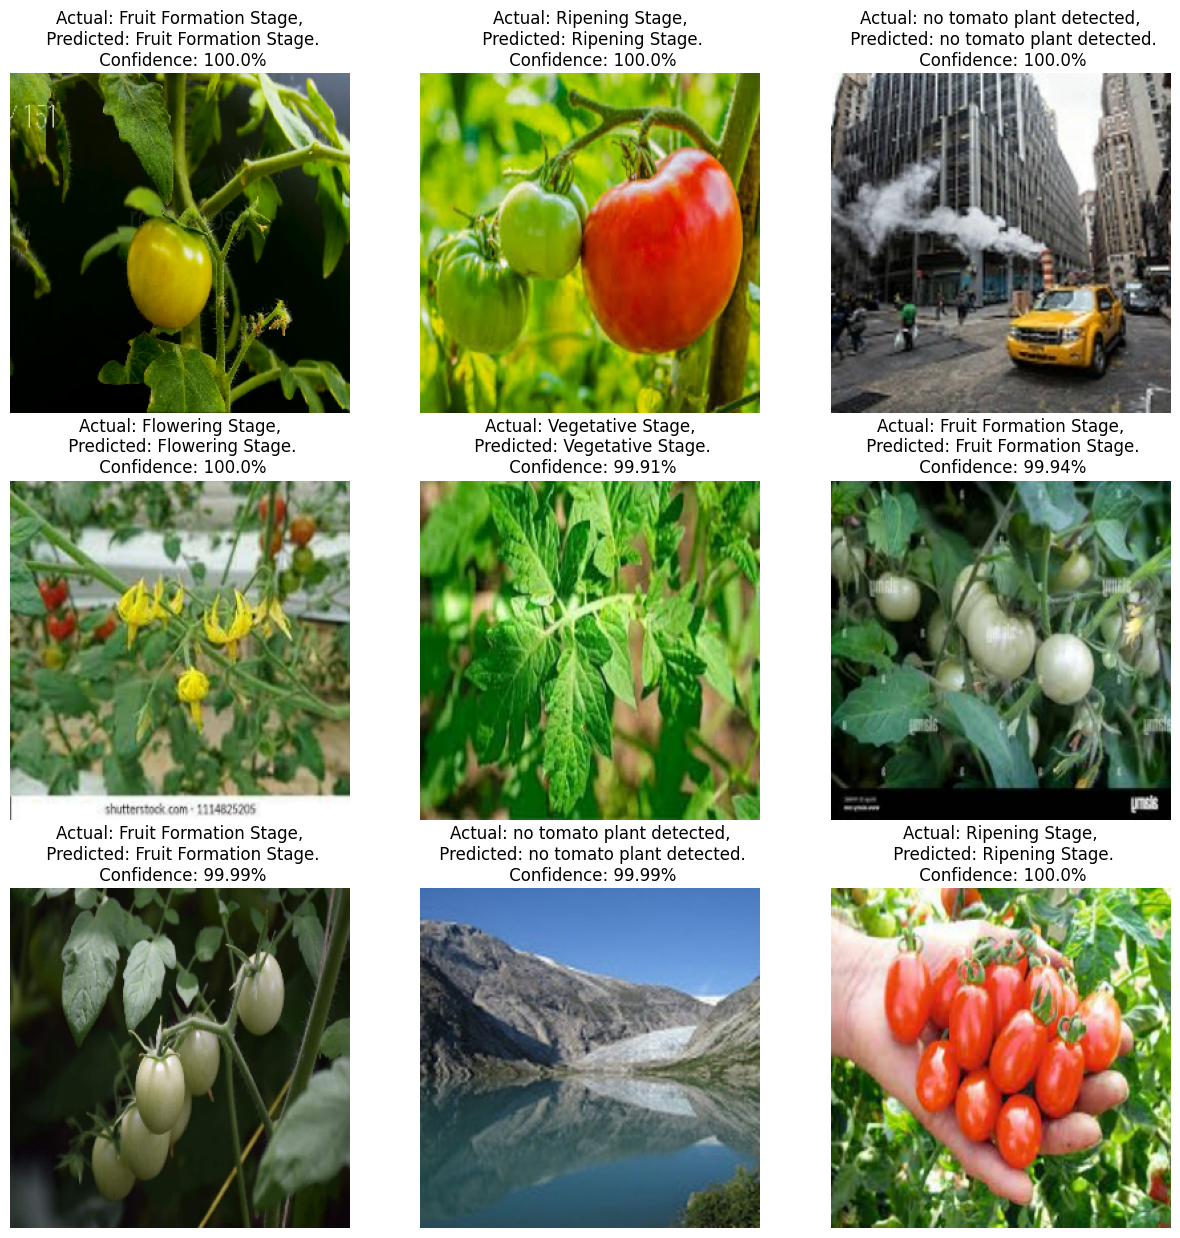

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [39]:
model.save("tomatoStagev5.h5")

C:\Users\fuyua\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## confusionMatrix

In [40]:
import numpy as np

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    # Get model predictions for the batch
    batch_predictions = model.predict(images_batch)
    
    # Convert predictions to class labels
    predicted_classes = np.argmax(batch_predictions, axis=1)
    
    # Append true and predicted labels to the lists
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_classes)


1/1 [==============================] - 1s 508ms/step


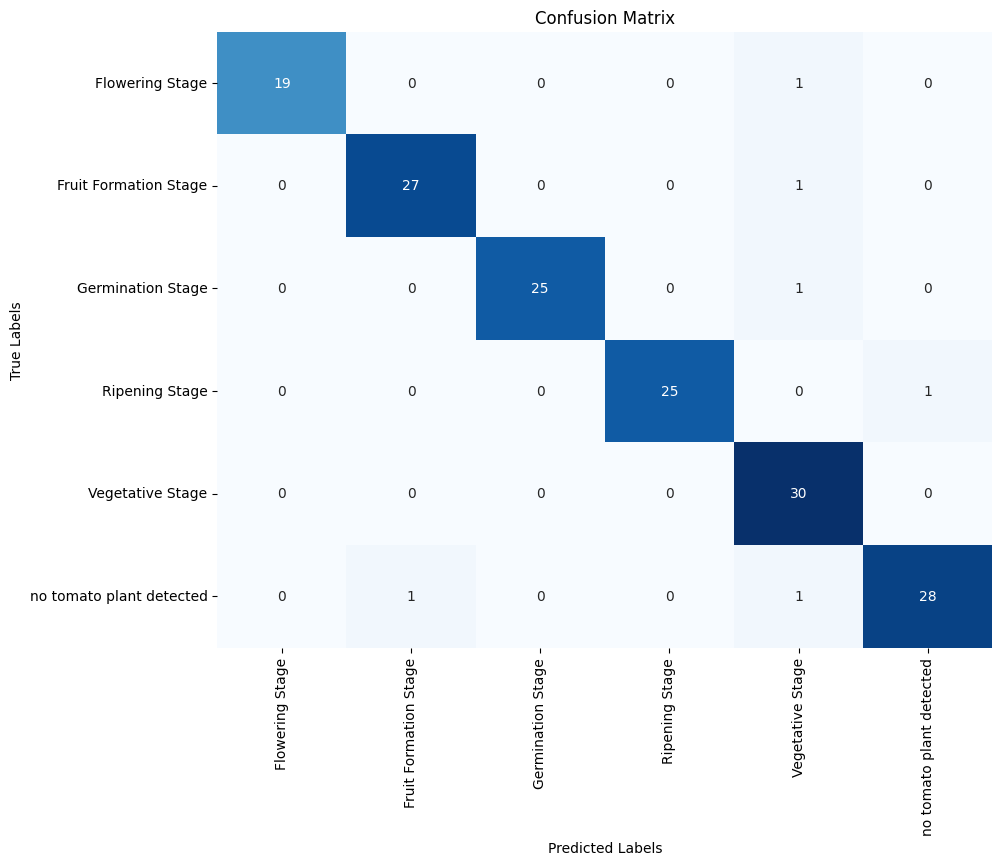

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Convert the confusion matrix to a DataFrame for visualization
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## precision, recall, and F1-score

In [42]:
from sklearn.metrics import classification_report

test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)



In [43]:
# Predict on the test set
predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
predicted_labels = tf.argmax(predictions, axis=1)

# Convert tensor to numpy array for classification report
true_labels = test_labels.numpy()
predicted_labels = predicted_labels.numpy()

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

5/5 [==============================] - 2s 501ms/step
                          precision    recall  f1-score   support

         Flowering Stage       1.00      0.95      0.97        20
   Fruit Formation Stage       0.96      0.96      0.96        28
       Germination Stage       1.00      0.96      0.98        26
          Ripening Stage       1.00      0.96      0.98        26
        Vegetative Stage       0.88      1.00      0.94        30
no tomato plant detected       0.97      0.93      0.95        30

                accuracy                           0.96       160
               macro avg       0.97      0.96      0.96       160
            weighted avg       0.97      0.96      0.96       160

